In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp
import pandas as pd
import os

In [2]:
data_dist = pd.read_csv("20201220.csv")

In [3]:
data_dist.head()

,time,lat,lon,elevation,accuracy,bearing,speed,satellites,provider,hdop,vdop,pdop,geoidheight,ageofdgpsdata,dgpsid,activity,battery,annotation
0,2020-12-20T15:10:17.000Z,50.750011,7.042619,134.840759,9.025899,183.3,0.42,0,gps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN
1,2020-12-20T15:11:17.676Z,50.750256,7.041907,116.290527,4.649731,286.3,1.26,0,gps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN
2,2020-12-20T15:12:18.862Z,50.750269,7.040532,131.785706,3.790093,266.9,0.95,0,gps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,NaN
3,2020-12-20T15:13:59.070Z,50.751304,7.039594,102.116760,6.074745,283.3,1.24,0,gps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN
4,2020-12-20T15:15:03.465Z,50.752021,7.038766,123.811890,6.938272,354.0,0.84,0,gps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,NaN


In [4]:
lat = data_dist.iloc[:,1]
print(len(lat))

22


In [5]:
true_mean = np.mean(lat)
true_std= np.std(lat)
print(true_mean,true_std)


50.753858130000005 0.0025479503627612254


In [6]:
sample_dist = np.random.normal(true_mean,true_std,len(lat))
samp_mean = np.mean(sample_dist)
samp_dist = np.std(sample_dist)
print(samp_mean,samp_dist)
print(len(sample_dist))

50.753614206602855 0.0030100459940152493
22


50.75373616830142 0.0019243295542180506
22


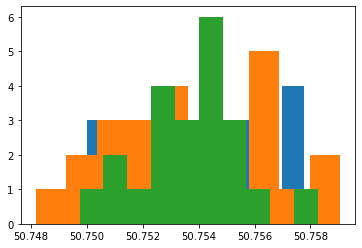

In [8]:
sum_dist = (sample_dist+lat)/2
print(np.mean(sum_dist),np.std(sum_dist))
plt.hist(lat)
plt.hist(sample_dist)
plt.hist(sum_dist)
print(len(sum_dist))


In [9]:
class MarkovChainMonteCarloSampler():
    
    def __init__(self,source):
        self.source = source
        self.iterations = 5000
        
    def prior(self,x):
        if(x[1] <=0):
            return 0
        return 1
    
    def transition_model(self,x):
        return [x[0],np.random.normal(x[1],0.5,(1,))[0]]

    def likelihood(self,x,data):
        return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))
    
    def accept(self,oldTrace,trace):
        if trace>oldTrace:
            return True
        else:
            accept=np.random.uniform(0,1)
            return (accept < (np.exp(trace-oldTrace)))
        
    def MarkovChainMonteCarloSampler(self):
        obs_mean = np.mean(self.source)
        x = [obs_mean,0.1]
        accepted = []
        rejected = [] 
        for i in range(self.iterations):
            x_new =  self.transition_model(x)    
            x_lik = self.likelihood(x,self.source)
            x_new_lik = self.likelihood(x_new,self.source) 
            oldtrace = x_lik + np.log(self.prior(x))
            newtrace = x_new_lik+np.log(self.prior(x_new))
            if (self.accept(oldtrace,newtrace)):            
                x = x_new
                accepted.append(x_new)
            else:
                rejected.append(x_new)  
        accepted = np.array(accepted)      
        burnin=int(-0.75*accepted.shape[0])
        mu=accepted[burnin:,0].mean()
        sigma=accepted[burnin:,1].mean()
        model = np.random.normal(mu,sigma,100)
        return model

In [10]:
class Sampler():
    def __init__(self):
        self.model = None

    def create(self,source):
        model = MarkovChainMonteCarloSampler(source).MarkovChainMonteCarloSampler()
        self.model = model
        #return model

    def Take(self,samples):
        return np.random.choice(self.model,samples)

In [11]:
def pr(source,numm_samples=10,prob=0.5,alpha=0.5,epsilon=0.03,max_samples=1,
      init_sample_size=1,sample_size_step=1):
    H_0=prob-epsilon
    H_1=prob+epsilon
    beta = alpha
    a = np.log(beta/(1-alpha))
    b= np.log((1-beta)/alpha)
    k=0
    
    w_sum=0.0
    w_sum_true=0.0
    s= Sampler()
    s.create(source)
    li = s.Take(10)
    count = 0.0
    for i in li:
        #print("first_for loop done")
        if i>=0.5:
            count=count+1
    count = count/len(li)
    num_samples=0
    while (num_samples<init_sample_size):
        #print("second_while loop done")
        if li[num_samples]>0.5:
            k=k+1
            w_sum_true=w_sum_true+count
        w_sum=w_sum+count
        num_samples+=1
    test = None
    while (numm_samples<= max_samples):
        #print(" loop done")
        log_likelihood = w_sum_true * np.log(H_1/H_0)+(w_sum-w_sum_true)*np.log((1-H_1)/(1-H_0))
        
        if (log_likelihood>=b):
            test=True
        elif (log_likelihood<=a):
            test = False
        else:
            i=0
            while (i<sample_size_step):
                count=0.0
                li=s.Take(10)
                for it in li:
                    if it>=0.5:
                        count=count+1
                count = count/len(li)
                
                if li[i]>0.5:
                    k=k+1
                    w_sum_true=w_sum_true+count
                w_sum=w_sum+count
                i=i+1
                numm_samples+=sample_size_step
        test = False
    
    return test

In [12]:
class Gaussian():
    def __init__(self,mu,std):
        self.mean = mu
        self.std = std
        self.samples = 1000
        
    def gaussian(self):
        population = np.random.normal(self.mean,self.std,self.samples)
        return population
    
class Operator:
    def __init__(self, val):
        self.val = val

    def __str__(self):
        return "({0},{1})".format(self.val)

    def __lt__(self, other):
        self_val = np.array(self.val)
        other_val = np.array(other.val)
        zeros_holder = np.zeros(len(self.val))
        lst= self_val < other_val
        dist = list(zeros_holder+lst)
        prob = dist.count(1)/len(dist)
        lst = self.flip(prob,len(dist))
        return lst
    
    def __gt__(self,other):
        self_val = np.array(self.val)
        other_val = np.array(other.val)
        zeros_holder=np.zeros(len(self.val))
        lst= self_val > other_val
        dist = list(zeros_holder+lst)
        prob = dist.count(1)/len(dist)
        lst = self.flip(prob,len(dist))
        return lst
    
    def flip(self,prob,dist_len):
        lst=[]
        for i in range(dist_len):
            random_prob = np.random.uniform(0.0,1.0)
            lst.append(int(random_prob<prob))
        return lst

In [13]:
path = os.getcwd()

In [14]:
Downloads/SDP/GUI Repo/SDP_Assignments/Uncertain_T/Uncertain_python/Uncertain

SyntaxError: invalid syntax (<ipython-input-14-666597ab5cf8>, line 1)

In [15]:
unc_fol = os.chdir("/home/dadi_vardhan/Downloads/SDP/GUI Repo/SDP_Assignments/Uncertain_T/Uncertain_python/")

In [16]:
pwd

'/home/dadi_vardhan/Downloads/SDP/GUI Repo/SDP_Assignments/Uncertain_T/Uncertain_python'

In [17]:
from Uncertain.Gaussian import Gaussian
from Uncertain.Uncertain import Operator

In [21]:
mmc_truth_dist = Gaussian(true_mean,true_std)
mmc_samp_dist = Gaussian(samp_mean,samp_dist)

final_dist = Operator(mmc_samp_dist)+Operator(mmc_truth_dist)

In [22]:
mmc_truth_dist = list(mmc_truth_dist.get_support())
mmc_samp_dist = list(mmc_samp_dist.get_support())
final_dist = list(final_dist/2)
print(np.mean(final_dist),np.std(final_dist))

50.75408116667567 0.0017548120180855054


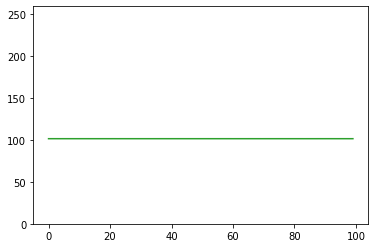

In [63]:
plt.hist(mmc_truth_dist)
plt.hist(mmc_samp_dist)
